In [ ]:
!git clone -b main https://github.com/ivan866/cvr_course

In [ ]:
cd cvr_course/notebooks

In [ ]:
#NOTE i have rtx2060 with tensorflow-gpu 2.2 locally; therefore, cuda 10.1
#!pip install -f https://download.pytorch.org/whl/torch_stable.html torch==1.8.0+cu101

In [1]:
import os, math, random

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

In [13]:
device=torch.device('cpu')
#device=torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)
#NOTE seems that both numpy, tensorflow and torch install Intel OpenMP [libiomp5md.dll]; that 'fixes' the issue
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

cpu


In [14]:
print(torch.__version__)
print(torch.backends.cuda.is_built())
print(torch.backends.cudnn.version())

1.8.0+cu101
True
7604


# Domik Dataset

In [6]:
class DomikDataset(Dataset):
    def __init__(self, dataset_size, noise=0.0):
        super().__init__()
        self.house_width = 0.6
        self.house_height = 0.7
        self.roof_height = 0.3
        
        self.points, self.targets = self._generate(dataset_size, noise)

    def _left_roof(self, point):
        b = (0.5 * self.house_height - (self.house_height + self.roof_height) * (1 - self.house_width) / 2) / \
            (0.5 - (1 - self.house_width) / 2)
        k =  2 * (self.house_height - b) / (1 - self.house_width)
        return k * point[0] + b >= point[1]

    def _right_roof(self, point):
        b = (0.5 * self.house_height - (self.house_height + self.roof_height) * (1 + self.house_width) / 2) / \
            (0.5 - (1 + self.house_width) / 2)
        k = 2 * (self.house_height - b) / (1 + self.house_width)
        return k * point[0] + b >= point[1]
    
    
    def _generate(self, size, noise):
        points = [[random.random(), random.random()] for i in range(size)]

        targets = []
        for point in points:
            if (1 - self.house_width) / 2 <= point[0] <= (1 + self.house_width) / 2 and \
                self._left_roof(point) and self._right_roof(point):   
                inside = 1.
            else:
                inside = 0.

            if random.random() < noise:
                inside = 1. - inside

            targets.append(torch.tensor([inside], device=device))

        return points, targets
    
    def show(self, dividing_criterion=lambda s: 1 if s > 0.5 else 0):
        domik_x = []
        domik_y = []
        nedomik_x = []
        nedomik_y = []

        for sample in self:
            point, target = sample
            if dividing_criterion(target):
                domik_x.append(point[0])
                domik_y.append(point[1])
            else: 
                nedomik_x.append(point[0])
                nedomik_y.append(point[1])

        plt.plot(domik_x, domik_y, '.', nedomik_x, nedomik_y,'.')

    def __len__(self):
        return len(self.points)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
               
        sample = (torch.tensor(self.points[idx], device=device), self.targets[idx])

        return sample

# Train function

In [4]:
def train(network, train_dataset, epochs, criterion, optimizer):
    loss_epochs = []
    for idx in range(epochs):
        loss_samples = []
        for sample in train_dataset:
            optimizer.zero_grad()   # zero the gradient buffers
            point, target = sample
            output = network(point)
            loss = criterion(output, target.to(device))
            loss.backward()
            loss_samples.append(loss.data.cpu().numpy())
            optimizer.step()    # Does the update

        loss_samples_mean = float(sum(loss_samples)) / len (loss_samples)
        print(f"Epoch {idx: >8} Loss: {loss_samples_mean}")
        loss_epochs.append(loss_samples_mean)

    plt.plot(loss_epochs)
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.show() 

# Test function

In [20]:
def test(network, test_dataset, dividing_criterion):
    domik_x = []
    domik_y = []
    nedomik_x = []
    nedomik_y = []

    correct = 0
    total = 0

    with torch.no_grad():
        for sample in test_dataset:
            inp, target = sample
            output = network(inp)
            total += 1
            correct += (dividing_criterion(output) == dividing_criterion(target))

            # dividing dataset for plotting
            if dividing_criterion(output):
                
                domik_x.append(inp[0])
                domik_y.append(inp[1])
            else: 
                nedomik_x.append(inp[0])
                nedomik_y.append(inp[1])
    
    plt.figure(figsize=(20,5))
    plt.subplot(121)
    test_dataset.show()
    plt.subplot(122)
    plt.plot(domik_x, domik_y, '.', nedomik_x, nedomik_y, '.')

    print(f'Accuracy of the network on the {total} test samples: {100 * correct / total}')

# First steps

## Dataset

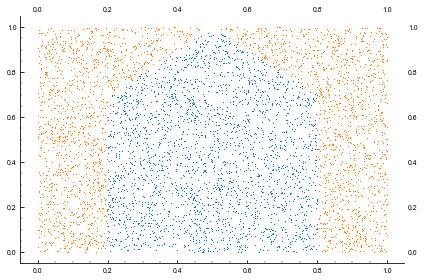

In [12]:
DATASET_SIZE = 5000
domik = DomikDataset(DATASET_SIZE)
data = DataLoader(domik, batch_size=5000)
domik.show()

## Net

In [13]:
#NOTE cant reach 98% accuracy with just one linear layer
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        # an affine operation: y = Wx + b
        self.fc1 = nn.Linear(2, 1)

    def forward(self, x):
        x = F.sigmoid(self.fc1(x))
        return x

net = Net().float().to(device)
print(net)

Net(
  (fc1): Linear(in_features=2, out_features=1, bias=True)
)


In [14]:
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        # an affine operation: y = Wx + b
        self.fc1 = nn.Linear(2, 45)
        self.fc2 = nn.Linear(45, 1)

    def forward(self, x):
        x = F.leaky_relu(self.fc1(x))
        x = F.leaky_relu(self.fc2(x))
        return x

net = Net().float().to(device)
print(net)

Net(
  (fc1): Linear(in_features=2, out_features=45, bias=True)
  (fc2): Linear(in_features=45, out_features=1, bias=True)
)


## Train

Epoch        0 Loss: 0.09790375074700566
Epoch        1 Loss: 0.05714151298132519
Epoch        2 Loss: 0.04844204931070621
Epoch        3 Loss: 0.04476456541567036
Epoch        4 Loss: 0.041936552429258804
Epoch        5 Loss: 0.04007949286818924
Epoch        6 Loss: 0.03886127228276704
Epoch        7 Loss: 0.037268685397773046
Epoch        8 Loss: 0.036531296650452946
Epoch        9 Loss: 0.03544854946897781
Epoch       10 Loss: 0.03416109540523228
Epoch       11 Loss: 0.03276203899203291
Epoch       12 Loss: 0.031445339948279236
Epoch       13 Loss: 0.030194918952344028
Epoch       14 Loss: 0.029065418021460003
Epoch       15 Loss: 0.028200433544230567
Epoch       16 Loss: 0.027320382967974444
Epoch       17 Loss: 0.026712816515096233
Epoch       18 Loss: 0.026593586792069607
Epoch       19 Loss: 0.02609123277772453
Epoch       20 Loss: 0.025700958713655166
Epoch       21 Loss: 0.02521769714146036
Epoch       22 Loss: 0.02506530566854065
Epoch       23 Loss: 0.02466787295308101
Epoch

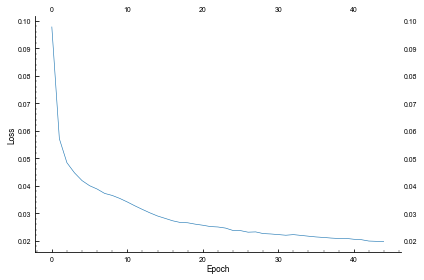

In [17]:
EPOCHS_TO_TRAIN = 45
train(network=net, 
      train_dataset=domik, 
      epochs=EPOCHS_TO_TRAIN, 
      criterion=nn.MSELoss(), 
      optimizer=optim.SGD(net.parameters(), lr=0.055))

## Test

Accuracy of the network on the 25000 test samples: 98.556


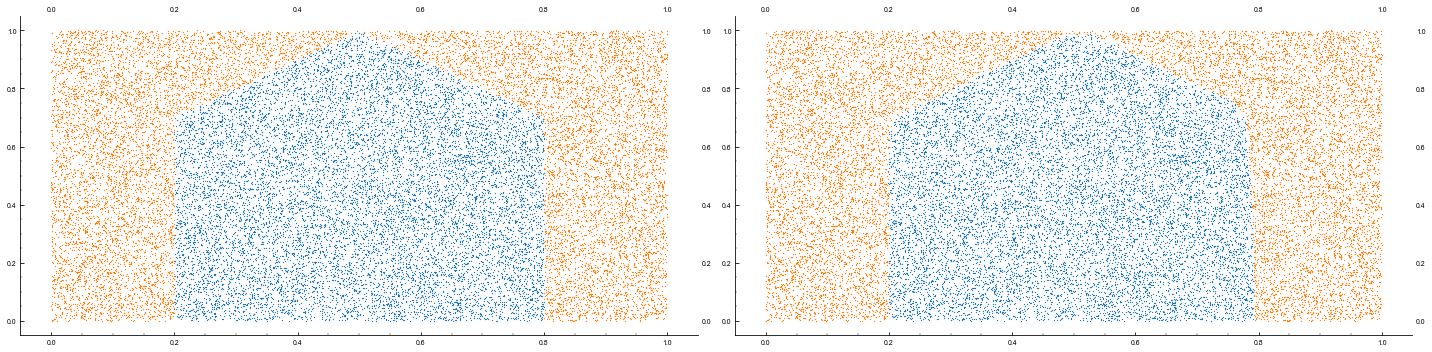

In [18]:
test_dataset = DomikDataset(DATASET_SIZE*5)
test(network=net, test_dataset=test_dataset, dividing_criterion=lambda s: 1 if s > 0.5 else 0)

# Domik dataset for multi classes

In [66]:
class MultiClassDomikDataset(DomikDataset):
    def __init__(self, dataset_size, noise=0.0):
        super().__init__(dataset_size, noise)
        
    def show(self, dividing_criterion=lambda s: s[0] > s[1]):
        #super().show(dividing_criterion)
        super().show()
        
    def _generate(self, size, noise):
        points, targets = super()._generate(size, noise)
        for i, target in enumerate(targets):
            targets[i] = int(targets[i].item())
        return points, targets

In [67]:
DATASET_SIZE = 5000
domik = MultiClassDomikDataset(DATASET_SIZE)
data = DataLoader(domik, batch_size=5000)
# plotting
domik.show()

RuntimeError: CUDA error: device-side assert triggered

## Net

In [44]:
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        # an affine operation: y = Wx + b
        self.fc1 = nn.Linear(2, 120)
        self.fc2 = nn.Linear(120, 45)
        self.fc3 = nn.Linear(45, 72)
        self.fc4 = nn.Linear(72, 2)

    def forward(self, x):
        x = F.leaky_relu(self.fc1(x))
        x = F.leaky_relu(self.fc2(x))
        x = F.leaky_relu(self.fc3(x))
        x = F.leaky_relu(self.fc4(x))
        return x

net = Net().float().to(device)
print(net)

Net(
  (fc1): Linear(in_features=2, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=45, bias=True)
  (fc3): Linear(in_features=45, out_features=72, bias=True)
  (fc4): Linear(in_features=72, out_features=2, bias=True)
)


## Train

Epoch        0 Loss: 0.6866226100921631
Epoch        1 Loss: 0.6496793967485428
Epoch        2 Loss: 0.5577869726717473
Epoch        3 Loss: 0.45830844912678004
Epoch        4 Loss: 0.2262618934176862
Epoch        5 Loss: 0.16543312354944648
Epoch        6 Loss: 0.1408041268121451
Epoch        7 Loss: 0.12386863207677379
Epoch        8 Loss: 0.11289400912588463
Epoch        9 Loss: 0.1050027504004538
Epoch       10 Loss: 0.10061466025188565
Epoch       11 Loss: 0.09587491267709992
Epoch       12 Loss: 0.09242201199987904
Epoch       13 Loss: 0.08884662384632974
Epoch       14 Loss: 0.0861140993796289
Epoch       15 Loss: 0.08354191075253765
Epoch       16 Loss: 0.08146386505570263
Epoch       17 Loss: 0.07960150096099823
Epoch       18 Loss: 0.07803143093187828
Epoch       19 Loss: 0.07633976382494438
Epoch       20 Loss: 0.07511729842808564
Epoch       21 Loss: 0.07373235475912225
Epoch       22 Loss: 0.07259076324990019
Epoch       23 Loss: 0.07164770937291905
Epoch       24 Loss: 0.

Epoch      200 Loss: 0.03405516916094711
Epoch      201 Loss: 0.03397050952433347
Epoch      202 Loss: 0.03379976189631634
Epoch      203 Loss: 0.03378953739316785
Epoch      204 Loss: 0.03367759711931285
Epoch      205 Loss: 0.03363965411992467
Epoch      206 Loss: 0.03361293210626173
Epoch      207 Loss: 0.03330300990091928
Epoch      208 Loss: 0.03346613522324333
Epoch      209 Loss: 0.033359022904587615
Epoch      210 Loss: 0.03326050994272009
Epoch      211 Loss: 0.03319904467467495
Epoch      212 Loss: 0.03326826322210764
Epoch      213 Loss: 0.03313119322874627
Epoch      214 Loss: 0.03311043884106766
Epoch      215 Loss: 0.03276467917747141
Epoch      216 Loss: 0.03307924569035094
Epoch      217 Loss: 0.03286658452519987
Epoch      218 Loss: 0.03284374182718239
Epoch      219 Loss: 0.03269241066849645
Epoch      220 Loss: 0.032677497330823826
Epoch      221 Loss: 0.032649709114375584
Epoch      222 Loss: 0.0323703594869221
Epoch      223 Loss: 0.032571734330231264
Epoch      22

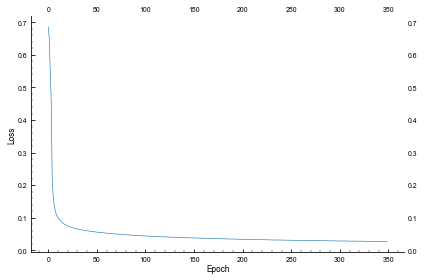

In [45]:
EPOCHS_TO_TRAIN = 350
train(network=net, 
      train_dataset=data, 
      epochs=EPOCHS_TO_TRAIN, 
      criterion=nn.CrossEntropyLoss(), 
      optimizer=optim.SGD(net.parameters(), lr=0.082))

## Test

In [46]:
def test_multiple(network, test_dataset, dividing_criterion):
    domik_x = []
    domik_y = []
    nedomik_x = []
    nedomik_y = []

    correct = 0
    total = 0

    with torch.no_grad():
        for sample in test_dataset:
            inp, target = sample
            output = network(inp)
            _, output = torch.max(output, 0)
            total += 1
            correct += (dividing_criterion(output) == dividing_criterion(target))

            # dividing dataset for plotting
            if dividing_criterion(output):
                
                domik_x.append(inp[0])
                domik_y.append(inp[1])
            else: 
                nedomik_x.append(inp[0])
                nedomik_y.append(inp[1])
    
    plt.figure(figsize=(20,5))
    plt.subplot(121)
    test_dataset.show()
    plt.subplot(122)
    plt.plot(domik_x, domik_y, '.', nedomik_x, nedomik_y, '.')

    print(f'Accuracy of the network on the {total} test samples: {100 * correct / total}')

Accuracy of the network on the 25000 test samples: 99.216


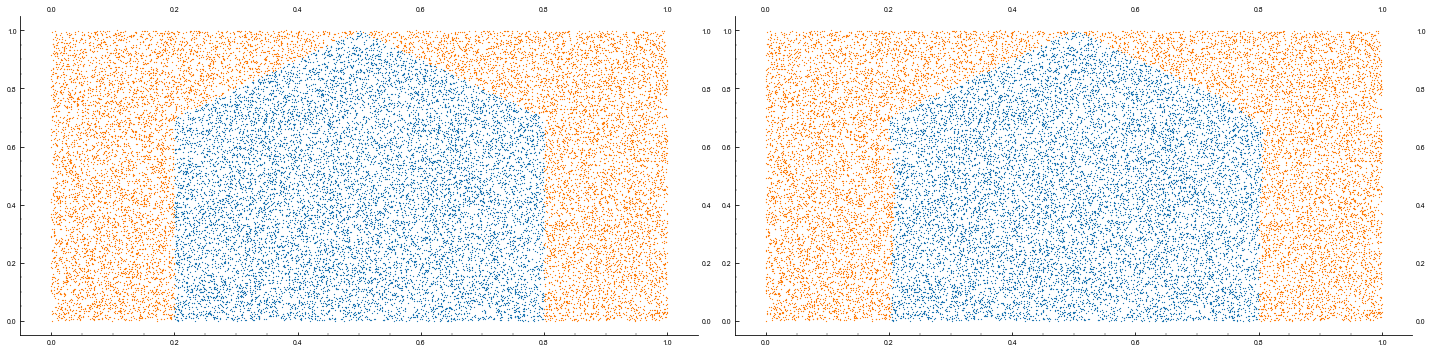

In [47]:
test_dataset = MultiClassDomikDataset(DATASET_SIZE*5)
test_multiple(network=net, test_dataset=test_dataset, dividing_criterion=lambda s: 1 if s > 0.5 else 0)

# Domik with window dataset

In [15]:
class WindowedDomikDataset(DomikDataset):
    def __init__(self, dataset_size, noise=0.0):
        super().__init__(dataset_size, noise)
        
    def _window(self, point, width=0.3, height=0.3, x=0.5, y='middle'):
        if y == 'middle':
            y = self.house_height / 2
        is_window = x - width / 2 <= point[0] <= x + width / 2 and \
            y - height / 2 <= point[1] <= y + height / 2
        return is_window
    
    def _generate(self, size, noise):
        points, targets = super()._generate(size, noise)
        for i, point in enumerate(points):
            if self._window(point):
                targets[i] = torch.tensor([0.], device=device)
        return points, targets

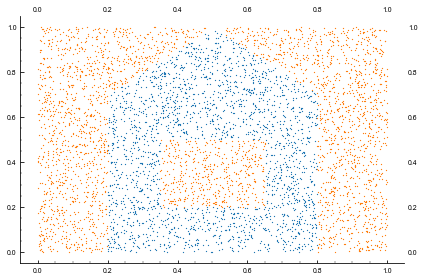

In [16]:
DATASET_SIZE = 5000
domik = WindowedDomikDataset(DATASET_SIZE)
# plotting
domik.show()

## Net

In [27]:
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        # an affine operation: y = Wx + b
        self.fc1 = nn.Linear(2, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 1)

    def forward(self, x):
        x = F.leaky_relu(self.fc1(x))
        x = F.leaky_relu(self.fc2(x))
        x = F.leaky_relu(self.fc3(x))
        return x

net = Net().float().to(device)
print(net)

Net(
  (fc1): Linear(in_features=2, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=1, bias=True)
)


## Train

Epoch        0 Loss: 0.20367251710996975
Epoch        1 Loss: 0.1365982023196207
Epoch        2 Loss: 0.12212308291438731
Epoch        3 Loss: 0.10775462643683054
Epoch        4 Loss: 0.0935901162185074
Epoch        5 Loss: 0.08553577866772062
Epoch        6 Loss: 0.07929094285760455
Epoch        7 Loss: 0.07186223759211949
Epoch        8 Loss: 0.06434219536709765
Epoch        9 Loss: 0.06006666741488941
Epoch       10 Loss: 0.05725225019601798
Epoch       11 Loss: 0.05545873534500929
Epoch       12 Loss: 0.05372147364668583
Epoch       13 Loss: 0.05148939551578824
Epoch       14 Loss: 0.05034791598259037
Epoch       15 Loss: 0.04920189584887997
Epoch       16 Loss: 0.04785784258851955
Epoch       17 Loss: 0.04669942100489191
Epoch       18 Loss: 0.04583670921906317
Epoch       19 Loss: 0.04502781346342613
Epoch       20 Loss: 0.044105857130610306
Epoch       21 Loss: 0.04326145388270145
Epoch       22 Loss: 0.04228800904446425
Epoch       23 Loss: 0.04124684039399898
Epoch       24 Lo

Epoch      198 Loss: 0.018139567515174322
Epoch      199 Loss: 0.018249750864238842
Epoch      200 Loss: 0.018225536558111932
Epoch      201 Loss: 0.018115599249152202
Epoch      202 Loss: 0.01829905340121
Epoch      203 Loss: 0.018581917467774142
Epoch      204 Loss: 0.018160479719343
Epoch      205 Loss: 0.018286543620171607
Epoch      206 Loss: 0.017834375247763892
Epoch      207 Loss: 0.018240662377274584
Epoch      208 Loss: 0.017843583548495426
Epoch      209 Loss: 0.01812220639911044
Epoch      210 Loss: 0.01810284811198546
Epoch      211 Loss: 0.018178668028414984
Epoch      212 Loss: 0.0177535670723508
Epoch      213 Loss: 0.01793542000838115
Epoch      214 Loss: 0.01784399507494441
Epoch      215 Loss: 0.017898566657484648
Epoch      216 Loss: 0.01779394320029465
Epoch      217 Loss: 0.017788883051419357
Epoch      218 Loss: 0.01797112466831245
Epoch      219 Loss: 0.017756690410255536


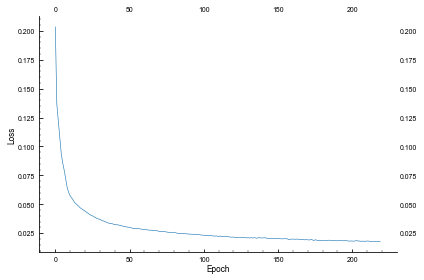

In [28]:
EPOCHS_TO_TRAIN = 220
train(network=net,
      train_dataset=domik, 
      epochs=EPOCHS_TO_TRAIN, 
      criterion=nn.MSELoss(), 
      optimizer=optim.SGD(net.parameters(), lr=0.0075))

## Test

Accuracy of the network on the 25000 test samples: 98.02


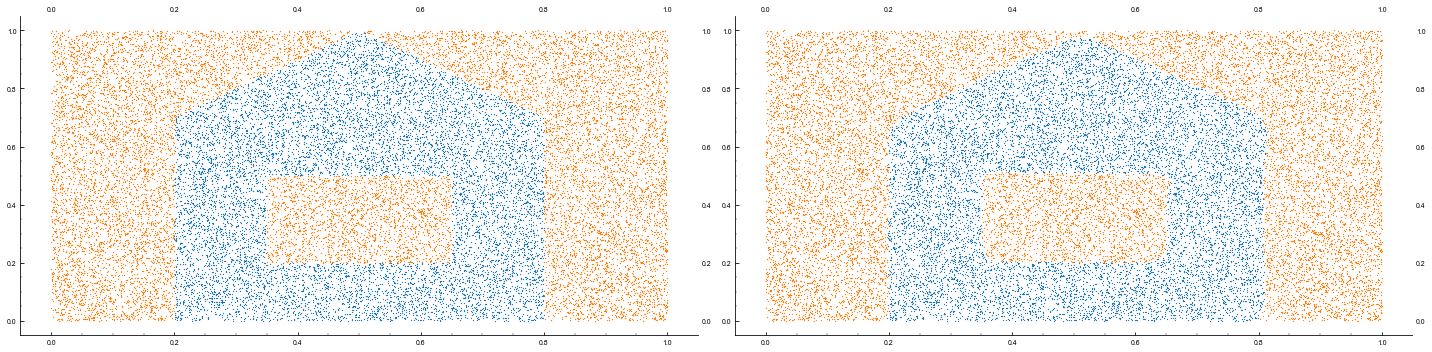

In [29]:
test_dataset = WindowedDomikDataset(DATASET_SIZE*5)
test(network=net, test_dataset=test_dataset, dividing_criterion=lambda s: 1 if s > 0.5 else 0)

# Homework

- [ ] Обучить обычный домик (Accuracy >98%). 1 балл
- [ ] Использовать для этого двухслойную сеть. 1 балл
- [ ] Обучить домик с многоклассовой классификацией (зa тавтологию извините) (Accuracy >98%). 1 балл
- [ ] Использовать для этого двухслойную сеть. 1 балл
- [ ] Обучить домик с окошком (Accuracy >98%). 1 балл
- [ ] Использовать для этого трехслойную сеть. 1 балл
- [ ] Обучить домик с дверью и двумя окошками (Accuracy >98%). 2 балла
- [ ] Использовать для этого трехслойную сеть. 2 балла

#### ВАЖНО! ВЫБОРКУ УВЕЛИЧИВАТЬ НЕЛЬЗЯ!

Домашку выполняем в этой тетрадке и заливаем на гит, инструкция - https://youtu.be/lPcEQJiHDfg. Форма для сдачи - https://forms.gle/RJtnENVjGP6H5oPn6 \
Удачи!

## Domik with door and 2 windows dataset

In [30]:
class DoorDomikDataset(WindowedDomikDataset):
    def __init__(self, dataset_size, noise=0.0):
        super().__init__(dataset_size, noise)
        
    def _door(self, point, width=0.2, height=0.5, x=0.5):
        y = height / 2
        is_door = x - width / 2 <= point[0] <= x + width / 2 and \
            y - height / 2 <= point[1] <= y + height / 2
        return is_door
    
    def _window(self, point, width=0.1, height=0.3, x=0.5, y='middle'):
        if y == 'middle':
            y = self.house_height / 2
        is_window = x - width / 2 <= point[0] <= x + width / 2 and \
            y - height / 2 <= point[1] <= y + height / 2
        return is_window
    
    def show(self):
        domik_x = []
        domik_y = []
        nedomik_x = []
        nedomik_y = []
        door_x = []
        door_y = []

        for sample in self:
            point, target = sample
            if target == 1:
                domik_x.append(point[0])
                domik_y.append(point[1])
            elif target == 0: 
                nedomik_x.append(point[0])
                nedomik_y.append(point[1])
            else:
                door_x.append(point[0])
                door_y.append(point[1])

        plt.plot(domik_x, domik_y, '.', nedomik_x, nedomik_y,'.', door_x, door_y, '.')
    def _generate(self, size, noise):
        points, targets = super()._generate(size, noise)
        for i, point in enumerate(points):
            if self._window(point, x=0.3):
                targets[i] = torch.tensor([0.], device=device)
            if self._window(point, x=0.7):
                targets[i] = torch.tensor([0.], device=device)
            if self._door(point):
                targets[i] = torch.tensor([2.], device=device)
                
            targets[i] = int(targets[i].item())
        return points, targets

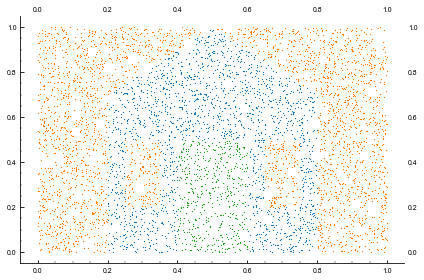

In [31]:
DATASET_SIZE = 5000
domik = DoorDomikDataset(DATASET_SIZE)
domik.show()

## Net

In [38]:
# create network here
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(2, 367)
        self.fc2 = nn.Linear(367, 288)
        self.fc3 = nn.Linear(288, 64)
        self.fc4 = nn.Linear(64, 192)
        self.fc5 = nn.Linear(192, 18)
        self.fc6 = nn.Linear(18, 1)

    def forward(self, x):
        x = F.leaky_relu(self.fc1(x))
        x = F.leaky_relu(self.fc2(x))
        x = F.leaky_relu(self.fc3(x))
        x = F.leaky_relu(self.fc4(x))
        x = F.leaky_relu(self.fc5(x))
        x = F.leaky_relu(self.fc6(x))
        return x

net = Net().float().to(device)
print(net)

Net(
  (fc1): Linear(in_features=2, out_features=367, bias=True)
  (fc2): Linear(in_features=367, out_features=288, bias=True)
  (fc3): Linear(in_features=288, out_features=64, bias=True)
  (fc4): Linear(in_features=64, out_features=192, bias=True)
  (fc5): Linear(in_features=192, out_features=18, bias=True)
  (fc6): Linear(in_features=18, out_features=1, bias=True)
)


## Train

In [39]:
# train here
#TODO not finished; some conflict of dtypes
def train(network, train_dataset, epochs, criterion, optimizer):
    loss_epochs = []
    for idx in range(epochs):
        loss_samples = []
        for sample in train_dataset:
            optimizer.zero_grad()   # zero the gradient buffers
            point, target = sample
            output = network(point)
            loss = criterion(output, target.to(device))
            loss.backward()
            loss_samples.append(loss.data.cpu().numpy())
            optimizer.step()    # Does the update

        loss_samples_mean = float(sum(loss_samples)) / len (loss_samples)
        print(f"Epoch {idx: >8} Loss: {loss_samples_mean}")
        loss_epochs.append(loss_samples_mean)

    plt.plot(loss_epochs)
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.show()

EPOCHS_TO_TRAIN = 560
train(network=net,
      train_dataset=domik, 
      epochs=EPOCHS_TO_TRAIN, 
      criterion=nn.MSELoss(), 
      optimizer=optim.SGD(net.parameters(), lr=0.007125))

AttributeError: 'int' object has no attribute 'to'

## Test

In [ ]:
def test_door_domik(network, test_dataset):
    domik_x = []
    domik_y = []
    nedomik_x = []
    nedomik_y = []
    door_x = []
    door_y = []

    correct = 0
    total = 0

    with torch.no_grad():
        for sample in test_dataset:
            inp, target = sample
            output = network(inp)
            _, output = torch.max(output, 0)
            total += 1
            correct += (output == target).sum().item()

            # dividing dataset for plotting
            if output == 1:
                domik_x.append(inp[0])
                domik_y.append(inp[1])
            elif output == 2:
                door_x.append(inp[0])
                door_y.append(inp[1])
            else: 
                nedomik_x.append(inp[0])
                nedomik_y.append(inp[1])
    
    plt.figure(figsize=(20,5))
    plt.subplot(121)
    test_dataset.show()
    plt.subplot(122)
    plt.plot(domik_x, domik_y, '.', nedomik_x, nedomik_y, '.', door_x, door_y, '.')

    print(f'Accuracy of the network on the {total} test samples: {100 * correct / total}')

In [ ]:
test_dataset = DoorDomikDataset(DATASET_SIZE*5)
test_door_domik(network=net, test_dataset=test_dataset)